In [1]:
import pandas as pd
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

## Load data

In [2]:
df = pd.read_csv('./data/TP_eng.csv')

In [3]:
X = df.drop(columns=['point','date','dx','dy'])
delta_x = df['dx']
delta_y = df['dy']

## Scale data

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler_data = MinMaxScaler() 
scaler_x = MinMaxScaler() 
scaler_y = MinMaxScaler()
scaler_data.fit(X)
X_scaled_array = scaler_data.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns = X.columns)

## Apply step-wise regression to x

In [5]:
X = X_scaled
y = delta_x
threshold_in = 0.05
included = backward_regression(X, y,
                       threshold_in,
                       verbose=False)
X_update = X[included]
included2 = forward_regression(X_update, y,
                       threshold_in,
                       verbose=False)
if included.sort() == included2.sort():
    print('algoithm ended with following selected features:\n',included)
else:
    print('please restart the update algorithm with X = X_update')

algoithm ended with following selected features:
 ['T', 'T10', 'T15', 'T20', 'day', 'day1', 'day2', 'h']


## Regression with selected feature

In [6]:
import numpy as np
X_included = X[included]
model = sm.OLS(y, X_included)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                     dx   R-squared (uncentered):                   0.824
Model:                            OLS   Adj. R-squared (uncentered):              0.824
Method:                 Least Squares   F-statistic:                              3283.
Date:                Sun, 22 Aug 2021   Prob (F-statistic):                        0.00
Time:                        14:47:37   Log-Likelihood:                         -2222.4
No. Observations:                5625   AIC:                                      4461.
Df Residuals:                    5617   BIC:                                      4514.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

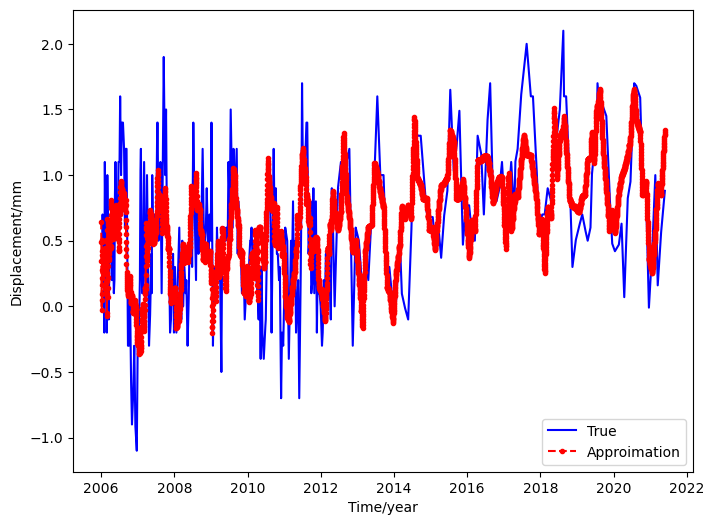

In [7]:
import numpy as np
import pandas as pd
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


dates = df['date']
myFmt = mdates.DateFormatter('%d')
fig, ax = plt.subplots(figsize=(8,6))
dates = range(13149, 13149+len(y))
ax.plot_date(dates, y, 'b-', label="True")
ax.plot_date(dates, res.fittedvalues, 'r--.', label="Approimation")
plt.ylabel('Displacement/mm')
plt.xlabel('Time/year')
# ax.xaxis.set_major_formatter(myFmt)
plt.legend()
plt.show()

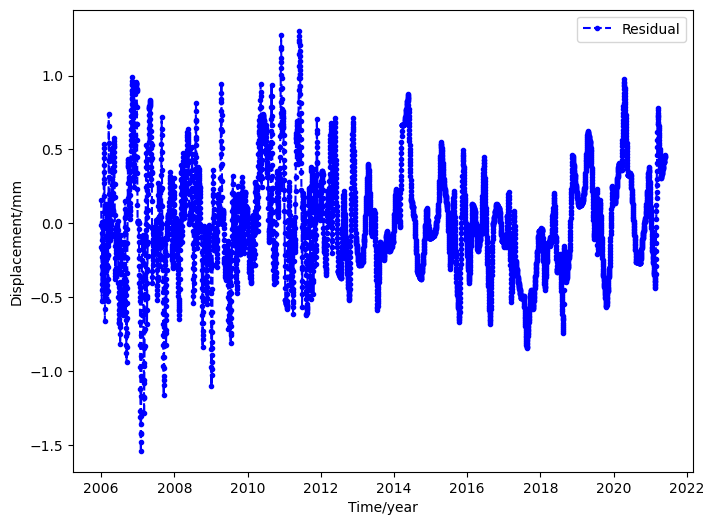

In [8]:
dates = df['date']
myFmt = mdates.DateFormatter('%d')
fig, ax = plt.subplots(figsize=(8,6))
dates = range(13149, 13149+len(y))
ax.plot_date(dates, res.fittedvalues-y, 'b--.', label="Residual")
plt.ylabel('Displacement/mm')
plt.xlabel('Time/year')
plt.legend()
plt.show()

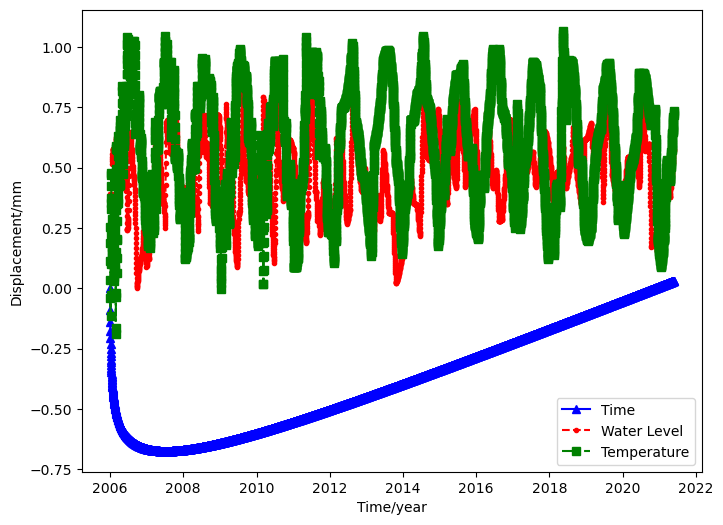

In [9]:
wX = X_included.multiply(res.params)
delta_tep = wX['T'] + wX['T10'] + wX['T15'] + wX['T20']
delta_time = wX['day'] + wX['day1'] + wX['day2']
delta_h = wX['h']
dates = df['date']
myFmt = mdates.DateFormatter('%d')
fig, ax = plt.subplots(figsize=(8,6))
dates = range(13149, 13149+len(y))
ax.plot_date(dates, delta_time, 'b^-', label="Time")
ax.plot_date(dates, delta_h, 'r--.', label="Water Level")
ax.plot_date(dates, delta_tep, 'gs-.', label="Temperature")
plt.ylabel('Displacement/mm')
plt.xlabel('Time/year')
# ax.xaxis.set_major_formatter(myFmt)
plt.legend()
plt.show()

## Apply step-wise regression to y

In [10]:
y = delta_y
threshold_in = 0.05
included = backward_regression(X, y,
                       threshold_in,
                       verbose=False)
X_update = X[included]
included2 = forward_regression(X_update, y,
                       threshold_in,
                       verbose=False)
if included.sort() == included2.sort():
    print('algoithm ended with following selected features:\n',included)
else:
    print('please restart the update algorithm with X = X_update')

algoithm ended with following selected features:
 ['T', 'T20', 'T5', 'day', 'day2', 'h', 'h2']


In [11]:
X_included = X[included]
model = sm.OLS(y, X_included)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                     dy   R-squared (uncentered):                   0.803
Model:                            OLS   Adj. R-squared (uncentered):              0.803
Method:                 Least Squares   F-statistic:                              3279.
Date:                Sun, 22 Aug 2021   Prob (F-statistic):                        0.00
Time:                        14:47:38   Log-Likelihood:                         -3961.1
No. Observations:                5625   AIC:                                      7936.
Df Residuals:                    5618   BIC:                                      7983.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

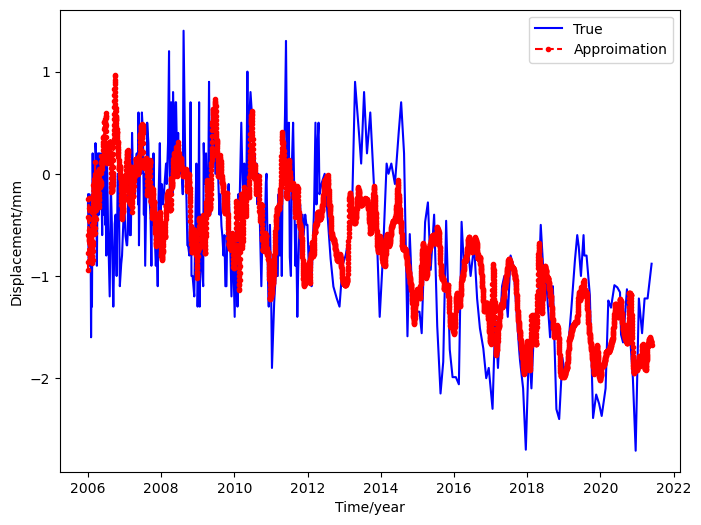

In [12]:
dates = df['date']
myFmt = mdates.DateFormatter('%d')
fig, ax = plt.subplots(figsize=(8,6))
dates = range(13149, 13149+len(y))
ax.plot_date(dates, y, 'b-', label="True")
ax.plot_date(dates, res.fittedvalues, 'r--.', label="Approimation")
plt.ylabel('Displacement/mm')
plt.xlabel('Time/year')
# ax.xaxis.set_major_formatter(myFmt)
plt.legend()
plt.show()

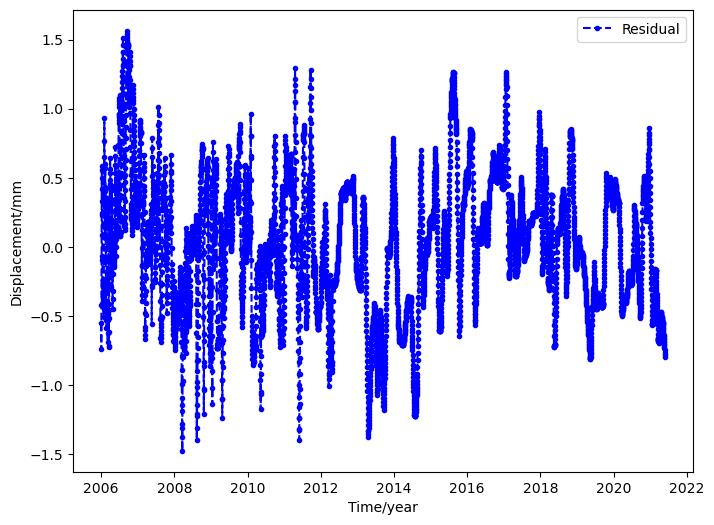

In [13]:
dates = df['date']
myFmt = mdates.DateFormatter('%d')
fig, ax = plt.subplots(figsize=(8,6))
dates = range(13149, 13149+len(y))
ax.plot_date(dates, res.fittedvalues-y, 'b--.', label="Residual")
plt.ylabel('Displacement/mm')
plt.xlabel('Time/year')
plt.legend()
plt.show()

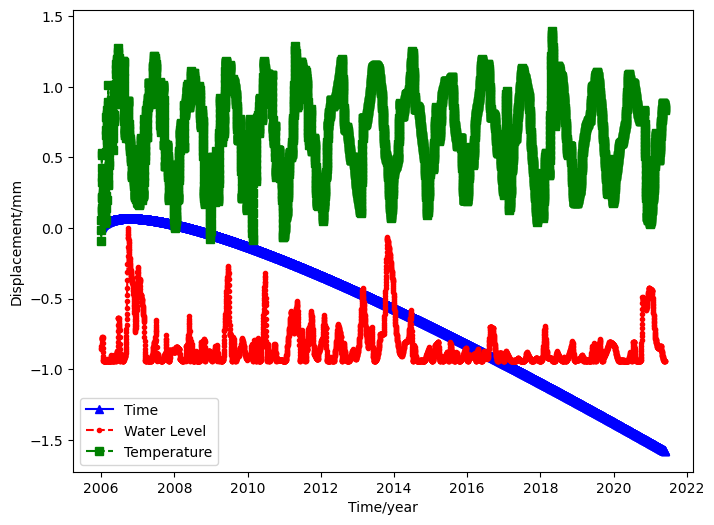

In [14]:
wX = X_included.multiply(res.params)
delta_tep = wX['T'] + wX['T5'] + wX['T20']
delta_time = wX['day']  + wX['day2']
delta_h = wX['h'] + wX['h2']
dates = df['date']
myFmt = mdates.DateFormatter('%d')
fig, ax = plt.subplots(figsize=(8,6))
dates = range(13149, 13149+len(y))
ax.plot_date(dates, delta_time, 'b^-', label="Time")
ax.plot_date(dates, delta_h, 'r--.', label="Water Level")
ax.plot_date(dates, delta_tep, 'gs-.', label="Temperature")
plt.ylabel('Displacement/mm')
plt.xlabel('Time/year')
# ax.xaxis.set_major_formatter(myFmt)
plt.legend()
plt.show()